In [63]:
import numpy as np
from scipy.stats import gamma, truncnorm, norm, lognorm, beta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF




In [64]:
num_samples = 1000


marginals = {
    "Inflation": gamma(a=2.0, scale=0.5).rvs(num_samples),  # Right-tailed (gamma)
    "Supply Chain Disruptions": norm(loc=1.0, scale=0.05).rvs(num_samples),  # Slightly right-tailed (normal)
    "Economies of Scale": beta(a=2, b=5).rvs(num_samples),  # Left-skewed (Beta)
    "Project Difficulty": lognorm(s=0.15, scale=np.exp(0.8)).rvs(num_samples),  # Log-normal for Project Difficulty
    "Market Demand": norm(loc=1.0, scale=0.1).rvs(num_samples),  # Normal
    "ESG Requirements": gamma(a=2.0, scale=0.5).rvs(num_samples),  # Right-tailed (gamma) for ESG Requirements
    "Baseline Overhead Cost": lognorm(s=0.3, scale=np.exp(5)).rvs(num_samples),  # Log-normal for baseline Overhead Cost
    "Baseline Transportation Cost": gamma(a=2.0, scale=75).rvs(num_samples),  # Gamma for baseline Transportation Cost
    "Baseline Testing Costs": norm(loc=300, scale=50).rvs(num_samples),  # Normal for baseline Testing Costs
    "Baseline Material Cost": norm(loc=300, scale=55).rvs(num_samples),  # Normal for baseline Material Costs
    "Baseline Tooling Cost": lognorm(s=0.15, scale=np.exp(5.3)).rvs(num_samples)  # Log-normal for Tooling Costs

}

marginal1 = {
    "Inflation": gamma(a=2.0, scale=0.5).rvs(num_samples),  # Right-tailed (gamma)
    "Supply Chain Disruptions": norm(loc=1.0, scale=0.05).rvs(num_samples),  # Slightly right-tailed (normal)
    "Economies of Scale": beta(a=2, b=5).rvs(num_samples),  # Left-skewed (Beta)
    "Project Difficulty": lognorm(s=0.15, scale=np.exp(0.8)).rvs(num_samples),  # Log-normal for Project Difficulty
    "Market Demand": norm(loc=1.0, scale=0.1).rvs(num_samples),  # Normal
    "ESG Requirements": gamma(a=2.0, scale=0.5).rvs(num_samples),  # Right-tailed (gamma) for ESG Requirements
    "Baseline Overhead Cost": lognorm(s=0.3, scale=np.exp(5)).rvs(num_samples),  # Log-normal for baseline Overhead Cost
    "Baseline Transportation Cost": gamma(a=2.0, scale=75).rvs(num_samples),  # Gamma for baseline Transportation Cost
    "Baseline Testing Costs": norm(loc=300, scale=50).rvs(num_samples),  # Normal for baseline Testing Costs
    "Baseline Material Cost": norm(loc=1.0, scale=0.1).rvs(num_samples),  # Normal for baseline Material Costs
    "Baseline Tooling Cost": lognorm(s=0.15, scale=np.exp(5.3)).rvs(num_samples)  # Log-normal for Tooling Costs

}

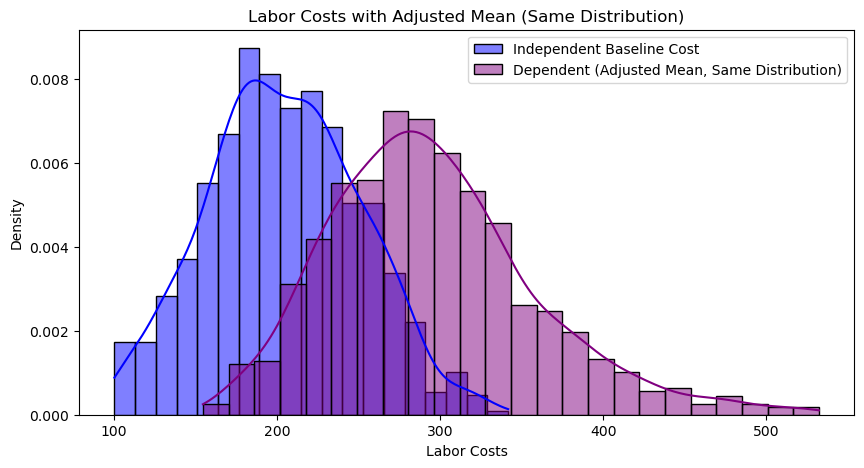

Mean Independent Labor Costs: 204.10218881912158
Mean Dependent Labor Costs (Adjusted Mean): 294.81130533591283


In [65]:
# LABOUR COSTS

import numpy as np
from scipy.stats import gamma, norm, truncnorm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Number of samples for Monte Carlo simulation
num_samples = 1000

# Step 1: Define Marginal Distributions for Dependencies and Labor Costs

# Step 2: Define Baseline Truncated Normal Distribution for Labor Costs
# Parameters for truncated normal (mean = 200, std dev = 50, limits 100 to 400)
a, b = (100 - 200) / 50, (400 - 200) / 50
baseline_cost = truncnorm(a, b, loc=200, scale=50).rvs(num_samples)

# Convert marginals to uniform [0, 1] scale for copula application
def transform_to_uniform(marginals):
    return {var: ECDF(data)(data) for var, data in marginals.items()}

uniform_marginals = transform_to_uniform(marginals)

# Step 3: Calculate Scaling Factor for Mean Shift
# Define weights for dependencies to increase mean cost
w1, w2 = 0.3, 0.2  # Adjust these weights based on influence
scaling_factor = 1 + w1 * marginals["Inflation"] + w2 * marginals["Supply Chain Disruptions"]

# Step 4: Calculate Adjusted Mean for the Labor Cost Distribution
# Shift the mean of the baseline cost distribution using the scaling factor
adjusted_mean = np.mean(baseline_cost) * scaling_factor

# Step 5: Apply Gumbel Copula for Shape Adjustment
def gumbel_copula(u, v, rho):
    return np.exp(-(((-np.log(u)) ** rho + (-np.log(v)) ** rho) ** (1 / rho)))

rho_gumbel = 10  # High rho for upper-tail dependence
effective_dependency = np.maximum(uniform_marginals["Inflation"], uniform_marginals["Supply Chain Disruptions"])
u_cost_dependency = gumbel_copula(effective_dependency, ECDF(baseline_cost)(baseline_cost), rho_gumbel)

# Step 6: Map Copula Output to Adjusted Truncated Normal Distribution Using Adjusted Mean
# Redefine the truncated normal distribution with the adjusted mean
def adjusted_truncnorm(mean, a, b, scale, u_values):
    loc = mean  # Adjusted mean
    return truncnorm(a, b, loc=loc, scale=scale).ppf(u_values)

# Mapping copula-adjusted uniform values to truncated normal with adjusted mean
dependent_labour_costs = adjusted_truncnorm(adjusted_mean, a, b, 50, u_cost_dependency)

# Plotting Comparison for Independent vs. Dependent Labor Costs
def plot_comparison(independent, dependent, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(independent, kde=True, color="blue", label="Independent Baseline Cost", stat="density")
    sns.histplot(dependent, kde=True, color="purple", label="Dependent (Adjusted Mean, Same Distribution)", stat="density")
    plt.xlabel("Labor Costs")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()

# Generate independent baseline labor costs for comparison and plot
independent_labour_costs = baseline_cost
plot_comparison(independent_labour_costs, dependent_labour_costs, "Labor Costs with Adjusted Mean (Same Distribution)")

# Display mean values for verification
mean_independent = np.mean(independent_labour_costs)
mean_dependent = np.mean(dependent_labour_costs)

print("Mean Independent Labor Costs:", mean_independent)
print("Mean Dependent Labor Costs (Adjusted Mean):", mean_dependent)



In [72]:
# OVERHEAD COSTS

# Step 2: Calculate Scaling Factor for Mean Shift
# Define weight for the dependency to increase mean overhead cost
w_esg = 0.3  # Weight for ESG Requirements influence
scaling_factor = 1.2 + w_esg * marginals["ESG Requirements"]

# Step 3: Calculate Adjusted Mean for the Overhead Cost Distribution
# Shift the mean of the baseline overhead cost distribution using the scaling factor
adjusted_mean = np.mean(marginals["Baseline Overhead Cost"]) * scaling_factor

# Step 4: Apply Gumbel Copula for Shape Adjustment
def gumbel_copula(u, v, rho):
    return np.exp(-(((-np.log(u)) ** rho + (-np.log(v)) ** rho) ** (1 / rho)))

rho_gumbel = 10  # High rho for upper-tail dependence
effective_dependency = uniform_marginals["ESG Requirements"]
u_cost_dependency = gumbel_copula(effective_dependency, uniform_marginals["Baseline Overhead Cost"], rho_gumbel)

# Step 5: Map Copula Output to Adjusted Overhead Cost Distribution Using Adjusted Mean
shape, baseline_scale = 0.3, np.exp(5)
dependent_overhead_costs = lognorm(s=shape, scale=adjusted_mean).ppf(u_cost_dependency)

# Plotting Comparison for Independent vs. Dependent Overhead Costs
def plot_comparison(independent, dependent, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(independent, kde=True, color="blue", label="Independent Baseline Cost", stat="density")
    sns.histplot(dependent, kde=True, color="purple", label="Dependent (Adjusted for Mean Shift and Copula)", stat="density")
    plt.xlabel("Overhead Costs")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()

# Generate independent baseline overhead costs for comparison and plot
independent_overhead_costs = lognorm(s=shape, scale=np.exp(5)).rvs(num_samples)
plot_comparison(independent_overhead_costs, dependent_overhead_costs, "Overhead Costs with Mean Shift and Copula Adjustment")

# Display mean values for verification
mean_independent = np.mean(independent_overhead_costs)
mean_dependent = np.mean(dependent_overhead_costs)

print("Mean Independent Overhead Costs:", mean_independent)
print("Mean Dependent Overhead Costs (Adjusted for Mean Shift and Copula):", mean_dependent)


KeyError: 'ESG Requirements'

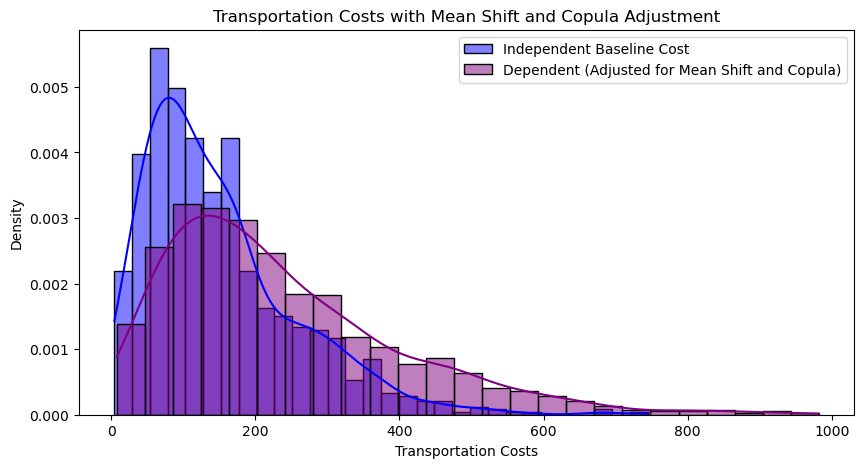

Mean Independent Transportation Costs: 149.49092615558484
Mean Dependent Transportation Costs (Adjusted for Mean Shift and Copula): 236.35053079831064


In [67]:
# TRANSPORTATION COSTS

# Step 2: Calculate Scaling Factor for Mean Shift
# Define weight for Supply Chain Disruptions to increase mean transportation cost
w_supply_chain = 1.5  # Weight for Supply Chain Disruptions influence
scaling_factor = 1 + w_supply_chain * marginals["Supply Chain Disruptions"]

# Step 3: Calculate Adjusted Mean for the Transportation Cost Distribution
# Shift the mean of the baseline transportation cost distribution using the scaling factor
adjusted_mean = np.mean(marginals["Baseline Transportation Cost"]) * scaling_factor

# Step 4: Apply Gumbel Copula for Shape Adjustment
def gumbel_copula(u, v, rho):
    return np.exp(-(((-np.log(u)) ** rho + (-np.log(v)) ** rho) ** (1 / rho)))

rho_gumbel = 10  # Moderate rho for upper-tail dependence
effective_dependency = uniform_marginals["Supply Chain Disruptions"]
u_cost_dependency = gumbel_copula(effective_dependency, uniform_marginals["Baseline Transportation Cost"], rho_gumbel)

# Step 5: Map Copula Output to Adjusted Gamma Distribution Using Adjusted Mean
# Use the adjusted mean in a gamma distribution to ensure we only shift the mean and keep the shape.
# Calculating the shape (k) and adjusted scale (theta) based on the adjusted mean
original_shape_param = 2.0  # Original shape parameter (a) for gamma
original_scale_param = 75   # Original scale parameter for gamma

# To adjust only the mean and keep the shape, calculate new scale (theta) as: adjusted_mean / shape_param
adjusted_scale_param = adjusted_mean / original_shape_param

# Map copula-adjusted uniform values to the gamma distribution with adjusted mean
dependent_transportation_costs = gamma(a=original_shape_param, scale=adjusted_scale_param).ppf(u_cost_dependency)

# Plotting Comparison for Independent vs. Dependent Transportation Costs
def plot_comparison(independent, dependent, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(independent, kde=True, color="blue", label="Independent Baseline Cost", stat="density")
    sns.histplot(dependent, kde=True, color="purple", label="Dependent (Adjusted for Mean Shift and Copula)", stat="density")
    plt.xlabel("Transportation Costs")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()

# Generate independent baseline transportation costs for comparison and plot
independent_transportation_costs = marginals["Baseline Transportation Cost"]
plot_comparison(independent_transportation_costs, dependent_transportation_costs, "Transportation Costs with Mean Shift and Copula Adjustment")

# Display mean values for verification
mean_independent = np.mean(independent_transportation_costs)
mean_dependent = np.mean(dependent_transportation_costs)

print("Mean Independent Transportation Costs:", mean_independent)
print("Mean Dependent Transportation Costs (Adjusted for Mean Shift and Copula):", mean_dependent)



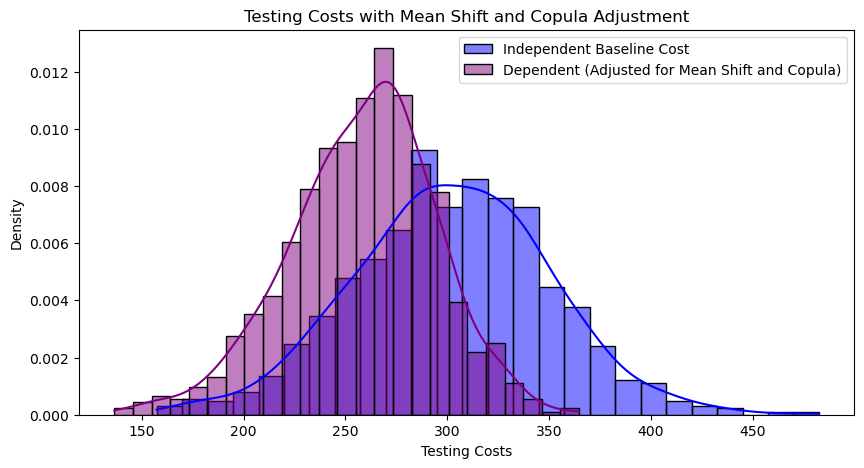

Mean Independent Testing Costs: 302.09614441012087
Mean Dependent Testing Costs (Adjusted Mean): 258.3353531040063


In [68]:
# TESTING COSTS

# Step 2: Calculate Scaling Factor for Mean Shift
# Define weight for Economies of Scale to adjust the mean of Testing Costs
w_economies_of_scale = -0.15  # Weight for Economies of Scale influence
scaling_factor = 1 + w_economies_of_scale * marginals["Economies of Scale"]

# Step 3: Calculate Adjusted Mean for the Testing Costs Distribution
# Shift the mean of the baseline Testing Costs distribution using the scaling factor
adjusted_mean = np.mean(marginals["Baseline Testing Costs"]) * scaling_factor

# Step 4: Apply Clayton Copula for Dependency Adjustment
def clayton_copula(u, v, theta):
    # Clayton copula formula: C(u, v) = max((u**(-theta) + v**(-theta) - 1)**(-1/theta), 0)
    return np.maximum((u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta), 0)

theta_clayton = 3  # Parameter for left-tail dependence in Clayton copula
effective_dependency = uniform_marginals["Economies of Scale"]
u_cost_dependency = clayton_copula(effective_dependency, uniform_marginals["Baseline Testing Costs"], theta_clayton)

# Step 5: Map Copula Output to Adjusted Normal Distribution Using Adjusted Mean
# Define normal distribution parameters with the adjusted mean to model the dependency-adjusted Testing Costs
def adjusted_normal(mean, scale, u_values):
    # Use mean as location, scale remains unchanged
    loc = mean
    return norm(loc=loc, scale=scale).ppf(u_values)

# Mapping copula-adjusted uniform values to normal with adjusted mean
dependent_testing_costs = adjusted_normal(adjusted_mean, 50, u_cost_dependency)

# Plotting Comparison for Independent vs. Dependent Testing Costs
def plot_comparison(independent, dependent, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(independent, kde=True, color="blue", label="Independent Baseline Cost", stat="density")
    sns.histplot(dependent, kde=True, color="purple", label="Dependent (Adjusted for Mean Shift and Copula)", stat="density")
    plt.xlabel("Testing Costs")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()

# Generate independent baseline testing costs for comparison and plot
independent_testing_costs = marginals["Baseline Testing Costs"]
plot_comparison(independent_testing_costs, dependent_testing_costs, "Testing Costs with Mean Shift and Copula Adjustment")

# Display mean values for verification
mean_independent = np.mean(independent_testing_costs)
mean_dependent = np.mean(dependent_testing_costs)

print("Mean Independent Testing Costs:", mean_independent)
print("Mean Dependent Testing Costs (Adjusted Mean):", mean_dependent)


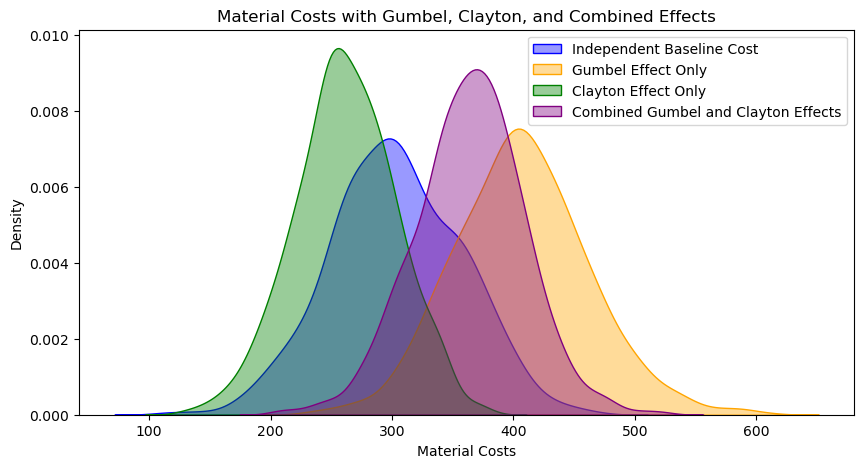

Mean Independent Material Costs: 303.16974348411213
Mean Material Costs (Gumbel Effect Only): 406.4314778644155
Mean Material Costs (Clayton Effect Only): 261.2515273788124
Mean Material Costs (Combined Effects): 363.6503473790286
Variance of Independent Material Costs: 2959.3027227824855
Variance of Material Costs (Gumbel Effect Only): 3090.4218604516423
Variance of Material Costs (Clayton Effect Only): 1725.6623780762104
Variance of Material Costs (Combined Effects): 2026.754116427786


In [69]:
# Step 2a: Calculate Scaling Factor for Gumbel Copula Dependencies
w_supply_chain = 0.15
w_market_demand = 0.1
w_inflation = 0.15
scaling_factor_gumbel = 1 + (
    w_supply_chain * marginals["Supply Chain Disruptions"]
    + w_market_demand * marginals["Market Demand"]
    + w_inflation * marginals["Inflation"]
)

# Step 2b: Calculate Scaling Factor for Clayton Copula Dependency
w_economies_of_scale = -0.05  # Negative weight for inverse relationship
scaling_factor_clayton = 1 + w_economies_of_scale * marginals["Economies of Scale"]

# Step 3: Compute Adjusted Means
baseline_mean = np.mean(marginals["Baseline Material Cost"])
adjusted_mean_gumbel = baseline_mean * scaling_factor_gumbel
adjusted_mean_clayton = baseline_mean * scaling_factor_clayton

# Combine adjusted means with weights
w_gumbel = 0.7  # Weight for Gumbel effect
w_clayton = 0.3  # Weight for Clayton effect
combined_adjusted_mean = (
    w_gumbel * adjusted_mean_gumbel + w_clayton * adjusted_mean_clayton
)


effective_dependency = np.maximum(uniform_marginals["Supply Chain Disruptions"], uniform_marginals["Market Demand"], uniform_marginals["Inflation"])
rho_gumbel = 3
                                                                                                                                       
u_gumbel_dependency = gumbel_copula(effective_dependency, uniform_marginals["Baseline Material Cost"], rho_gumbel)                                                                                                                                       

def gumbel_copula(u, v, rho):
    return np.exp(-(((-np.log(u)) ** rho + (-np.log(v)) ** rho) ** (1 / rho)))


# Step 5b: Apply Clayton Copula for Left-Tail Dependency with Economies of Scale
def clayton_copula(u, v, theta):
    return np.maximum((u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta), 0)


theta_clayton = 1  # Reduced theta for subtle left-tail dependence
u_clayton_dependency = clayton_copula(
    uniform_marginals["Economies of Scale"], 
    uniform_marginals["Baseline Material Cost"], 
    theta_clayton  # Ensure theta is passed correctly
)


# Step 5: Blend Copula Outputs with Weights
u_combined_dependency = (
    w_gumbel * u_gumbel_dependency + w_clayton * u_clayton_dependency
)

# Step 6: Map Copula Outputs to Final Adjusted Cost Distributions
def adjusted_normal(mean, scale, u_values):
    loc = mean
    return norm(loc=loc, scale=scale).ppf(u_values)

# Gumbel effect only
dependent_material_costs_gumbel = adjusted_normal(adjusted_mean_gumbel, 55, u_gumbel_dependency)

# Clayton effect only
dependent_material_costs_clayton = adjusted_normal(adjusted_mean_clayton, 55, u_clayton_dependency)

# Combined effect
dependent_material_costs_combined = adjusted_normal(combined_adjusted_mean, 55, u_combined_dependency)

# Step 7: Plot all adjustments
def plot_combined_effects(independent, gumbel, clayton, combined, title):
    plt.figure(figsize=(10, 5))

    sns.kdeplot(independent, color="blue", fill=True, label="Independent Baseline Cost", alpha=0.4)
    sns.kdeplot(gumbel, color="orange", fill=True, label="Gumbel Effect Only", alpha=0.4)
    sns.kdeplot(clayton, color="green", fill=True, label="Clayton Effect Only", alpha=0.4)
    sns.kdeplot(combined, color="purple", fill=True, label="Combined Gumbel and Clayton Effects", alpha=0.4)

    plt.xlabel("Material Costs")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()

# Generate independent baseline material costs for comparison
independent_material_costs = marginals["Baseline Material Cost"]

# Plot the effects
plot_combined_effects(
    independent_material_costs,
    dependent_material_costs_gumbel,
    dependent_material_costs_clayton,
    dependent_material_costs_combined,
    "Material Costs with Gumbel, Clayton, and Combined Effects"
)

# Display mean values for verification
mean_independent = np.mean(independent_material_costs)
mean_gumbel = np.mean(dependent_material_costs_gumbel)
mean_clayton = np.mean(dependent_material_costs_clayton)
mean_combined = np.mean(dependent_material_costs_combined)

print("Mean Independent Material Costs:", mean_independent)
print("Mean Material Costs (Gumbel Effect Only):", mean_gumbel)
print("Mean Material Costs (Clayton Effect Only):", mean_clayton)
print("Mean Material Costs (Combined Effects):", mean_combined)

# Display variance values for verification
variance_independent = np.var(independent_material_costs)
variance_gumbel = np.var(dependent_material_costs_gumbel)
variance_clayton = np.var(dependent_material_costs_clayton)
variance_combined = np.var(dependent_material_costs_combined)

print("Variance of Independent Material Costs:", variance_independent)
print("Variance of Material Costs (Gumbel Effect Only):", variance_gumbel)
print("Variance of Material Costs (Clayton Effect Only):", variance_clayton)
print("Variance of Material Costs (Combined Effects):", variance_combined)


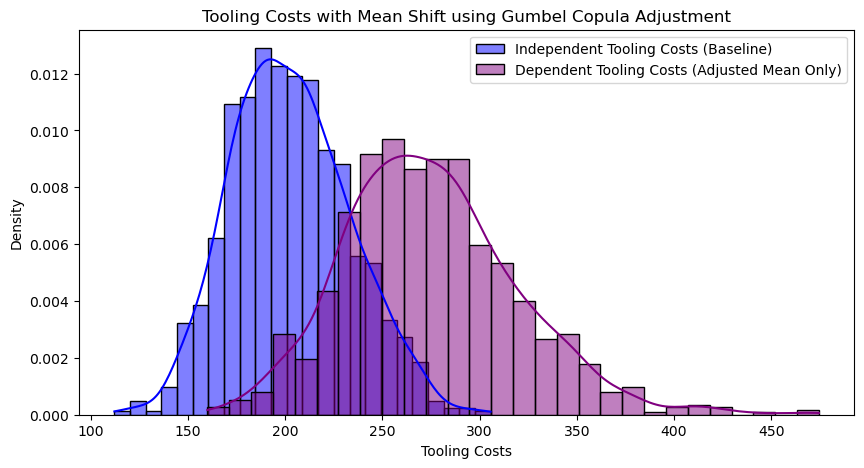

Mean Independent Tooling Costs: 202.5657134459215
Mean Dependent Tooling Costs (Adjusted Mean): 274.7538446606081


In [70]:
import numpy as np
from scipy.stats import lognorm, norm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
# Number of samples for Monte Carlo simulation
num_samples = 1000

# Step 1: Define Marginal Distributions for Dependencies and Tooling Costs
marginals = {
    "Project Difficulty": lognorm(s=0.15, scale=np.exp(2)).rvs(num_samples),  # Log-normal for Project Difficulty
    "Market Demand": norm(loc=1.0, scale=0.1).rvs(num_samples),  # Normal for Market Demand
    "Baseline Tooling Cost": lognorm(s=0.15, scale=np.exp(5.3)).rvs(num_samples)  # Log-normal for Tooling Costs
}

# Convert marginals to uniform [0, 1] scale for copula application
def transform_to_uniform(marginals):
    return {var: ECDF(data)(data) for var, data in marginals.items()}

uniform_marginals = transform_to_uniform(marginals)

# Step 2: Calculate Effective Dependency and Scaling Factor for Mean Shift
# Define weights for dependencies
w_project_difficulty = 0.1  # Weight for Project Difficulty
w_market_demand = 0.15      # Weight for Market Demand

effective_dependency = np.maximum(uniform_marginals["Project Difficulty"], uniform_marginals["Market Demand"])

# Scaling factor to adjust the mean
scaling_factor = 0.5 + w_project_difficulty * marginals["Project Difficulty"] + w_market_demand * marginals["Market Demand"]

# Step 3: Calculate Adjusted Mean for the Tooling Cost Distribution
baseline_mean = np.mean(marginals["Baseline Tooling Cost"])
adjusted_mean = baseline_mean * scaling_factor

# Step 4: Apply Gumbel Copula for Dependency Adjustment
def gumbel_copula(u, v, rho):
    # Bivariate Gumbel copula formula
    return np.exp(-(((-np.log(u)) ** rho + (-np.log(v)) ** rho) ** (1 / rho)))

rho_gumbel = 10  # High rho for upper-tail dependence
u_cost_dependency = gumbel_copula(effective_dependency, uniform_marginals["Baseline Tooling Cost"], rho_gumbel)


# Step 5: Map Copula Output to Adjusted Tooling Cost Distribution Using Adjusted Mean
def adjusted_lognorm(mean, shape, u_values):
    scale = mean  # Use the adjusted mean for scaling
    return lognorm(s=shape, scale=scale).ppf(u_values)

shape = 0.15  # Shape parameter for log-normal distribution of Tooling Costs
dependent_tooling_costs = adjusted_lognorm(adjusted_mean, shape, u_cost_dependency)

# Step 6: Plotting Comparison for Independent vs. Dependent Tooling Costs
def plot_comparison(independent, dependent, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(independent, kde=True, color="blue", label="Independent Tooling Costs (Baseline)", stat="density")
    sns.histplot(dependent, kde=True, color="purple", label="Dependent Tooling Costs (Adjusted Mean Only)", stat="density")
    plt.xlabel("Tooling Costs")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()

# Generate independent baseline tooling costs for comparison and plot
independent_tooling_costs = marginals["Baseline Tooling Cost"]
plot_comparison(
    independent_tooling_costs,
    dependent_tooling_costs,
    "Tooling Costs with Mean Shift using Gumbel Copula Adjustment"
)

# Display mean values for verification
mean_independent = np.mean(independent_tooling_costs)
mean_dependent = np.mean(dependent_tooling_costs)

print("Mean Independent Tooling Costs:", mean_independent)
print("Mean Dependent Tooling Costs (Adjusted Mean):", mean_dependent)


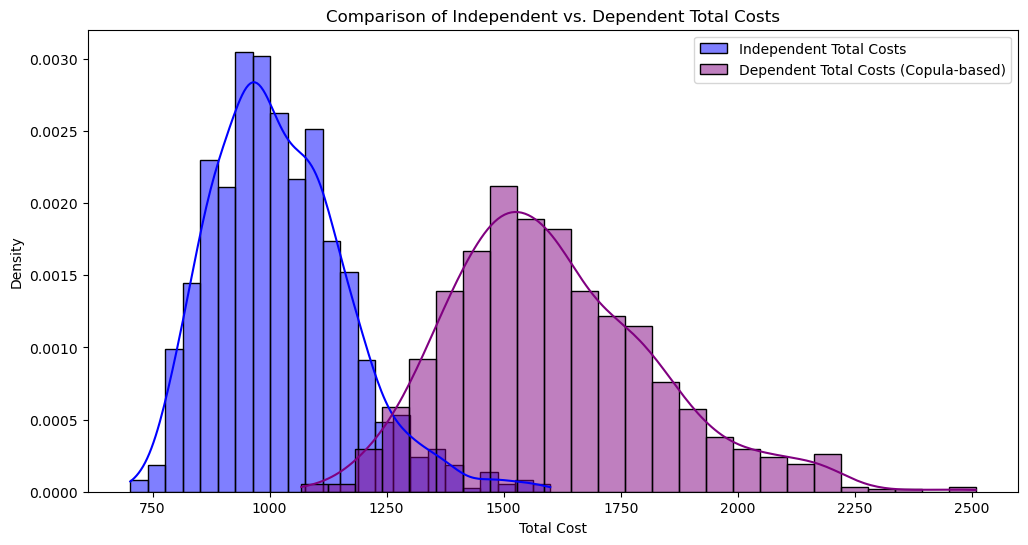

Mean Independent Total Costs: 1021.3835911443447
Mean Dependent Total Costs: 1605.9894637950458


In [71]:
# Define independent costs from the baseline distributions
independent_labour_costs = baseline_cost  # For Labour Costs
independent_overhead_costs = marginal1["Baseline Overhead Cost"]  # For Overhead Costs
independent_transportation_costs = marginal1["Baseline Transportation Cost"]  # For Transportation Costs
independent_testing_costs = marginal1["Baseline Testing Costs"]  # For Testing Costs
independent_material_costs = marginal1["Baseline Material Cost"]  # For Material Costs
independent_tooling_costs = marginal1["Baseline Tooling Cost"]  # For Tooling Costs

# Summing the independent costs
independent_total_costs = (
    independent_labour_costs +
    independent_overhead_costs +
    independent_transportation_costs +
    independent_testing_costs +
    independent_material_costs +
    independent_tooling_costs
)

# Summing the dependent costs
dependent_total_costs = (
    dependent_labour_costs +
    dependent_overhead_costs +
    dependent_transportation_costs +
    dependent_testing_costs +
    dependent_material_costs_combined +
    dependent_tooling_costs
)

# Plot total cost comparison
plt.figure(figsize=(12, 6))
sns.histplot(independent_total_costs, kde=True, color="blue", label="Independent Total Costs", stat="density", alpha=0.5)
sns.histplot(dependent_total_costs, kde=True, color="purple", label="Dependent Total Costs (Copula-based)", stat="density", alpha=0.5)
plt.xlabel("Total Cost")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of Independent vs. Dependent Total Costs")
plt.show()

# Display total mean values for verification
mean_independent_total = np.mean(independent_total_costs)
mean_dependent_total = np.mean(dependent_total_costs)

print("Mean Independent Total Costs:", mean_independent_total)
print("Mean Dependent Total Costs:", mean_dependent_total)
